In [1]:
# ! pip install transformers flask pandas scikit-learn

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("tweet_emotions.csv", usecols = ["content","sentiment"])

In [4]:
import re
from typing import List
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# max_features=5000

class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)  # Remove HTML tags
        text = re.sub('[^A-Za-z0-9]+', ' ', text)  # Remove special characters
        return text.lower()

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def init_bag_of_words(self, end_range: int):
        self.count = CountVectorizer(ngram_range=(1, end_range))
        return self.count

    def bag_of_words(self, text: List[str]):
        """
        Compute the Bag of Words matrix for the given list of texts.
        """
        return self.count.fit_transform(text)

    def init_tf_idf(self, end_range: int):
        self.tf_idf_ = TfidfVectorizer(ngram_range=(1, end_range))
        return self.tf_idf_

    def tf_idf(self, text: List[str]):
        """
        Compute the TF-IDF matrix for the given list of texts.
        """
        return self.tf_idf_.fit_transform(text)

    @staticmethod
    def plot_word_cloud(data, title):
        wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(
            data)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return

In [5]:
text_wrangler = TextWrangler()

In [6]:
df['content'] = (df['content']
                     .apply(text_wrangler.remove_digit)
                     .apply(text_wrangler.clean_text)
                     .apply(text_wrangler.word_lengthening)
                     .apply(text_wrangler.remove_stopwords))

In [10]:
def generate_word_cloud(category: str, type: str):
    if type == 'tf_idf':
        X_category_tfidf = text_wrangler.tf_idf(df[category])

        X_category_tfidf_df = pd.DataFrame(
            X_category_tfidf.toarray(), columns=text_wrangler.tf_idf_.get_feature_names_out()
        )

        # Calculate the sum of TF-IDF scores for each word
        tfidf_word_frequency = X_category_tfidf_df.sum(axis=0).sort_values(ascending=False)

        # Plot word cloud for TF-IDF
        text_wrangler.plot_word_cloud(tfidf_word_frequency, f'{category} Word Cloud using TF-IDF')
    elif type == 'bag_of_words':
        X_category_bow = text_wrangler.bag_of_words(df[category])

        X_category_bow_df = pd.DataFrame(X_category_bow.toarray(), columns=text_wrangler.count.get_feature_names_out())

        # Calculate the sum of word counts for each word
        bow_word_frequency = X_category_bow_df.sum(axis=0).sort_values(ascending=False)

        # Plot word cloud for Bag of Words
        text_wrangler.plot_word_cloud(bow_word_frequency, f'{category} Word Cloud for Bag of Words')

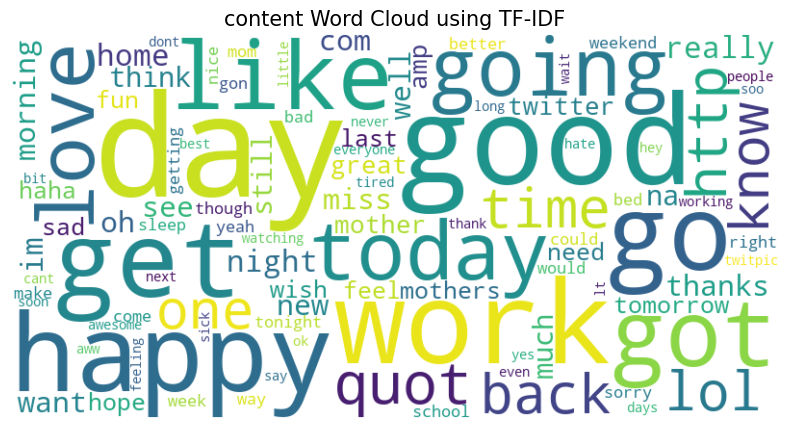

In [11]:
# Fit and transform the 'Content' columns using tf_idf

generate_word_cloud(category='content', type='tf_idf')

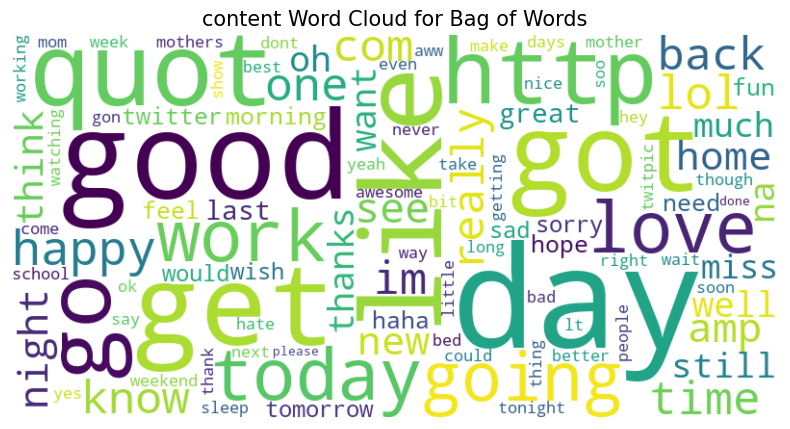

In [12]:
# Fit and transform the 'Content' columns using bag_of_words

generate_word_cloud(category='content', type='bag_of_words')

In [7]:
from sklearn.model_selection import train_test_split
X = df['content']
y = df['sentiment']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=15)  # Adjust num_labels as per your task


# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Tokenize the dataset
train_encodings = bert_tokenizer.batch_encode_plus(X_train, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = bert_tokenizer.batch_encode_plus(X_val, truncation=True, padding=True, max_length=128, return_tensors="pt")

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are converted to torch.long

    def __getitem__(self, idx):
        item = {key: val[idx].to(torch.long) for key, val in self.encodings.items()}  # Ensure input_ids, attention_mask are torch.long
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets using encoded labels
train_dataset = EmotionDataset(train_encodings, y_train_encoded)
val_dataset = EmotionDataset(val_encodings, y_val_encoded)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Define Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\botus\anaconda3\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.988900,1.857752
2,2.005200,1.885789
3,1.424300,2.067203


TrainOutput(global_step=12000, training_loss=1.687716004451116, metrics={'train_runtime': 40170.9498, 'train_samples_per_second': 2.39, 'train_steps_per_second': 0.299, 'total_flos': 2516293138752000.0, 'train_loss': 1.687716004451116, 'epoch': 3.0})

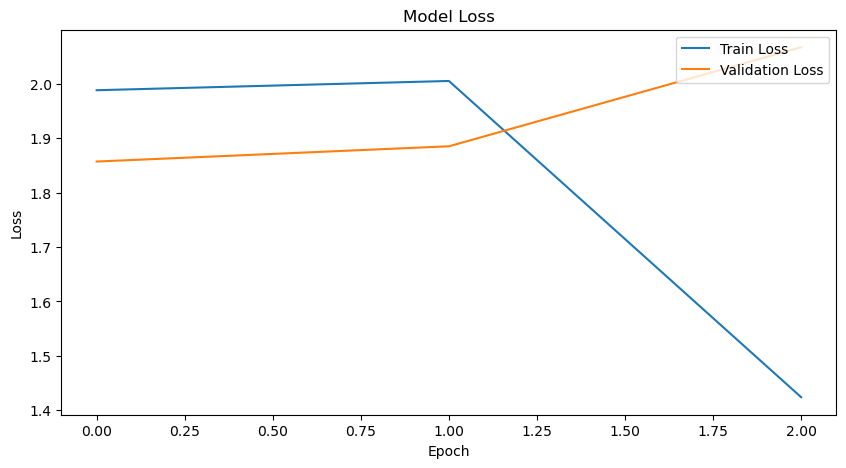

In [12]:
train_loss = [1.988, 2.005, 1.424]
val_loss = [1.857, 1.885, 2.067] 

# Plotting training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

output_dir = "./saved_model/"
bert_model = BertForSequenceClassification.from_pretrained(output_dir)
bert_tokenizer = BertTokenizer.from_pretrained(output_dir)

# Tokenize the dataset
train_encodings = bert_tokenizer.batch_encode_plus(X_train, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = bert_tokenizer.batch_encode_plus(X_val, truncation=True, padding=True, max_length=128, return_tensors="pt")

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are converted to torch.long

    def __getitem__(self, idx):
        item = {key: val[idx].to(torch.long) for key, val in self.encodings.items()}  # Ensure input_ids, attention_mask are torch.long
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets using encoded labels
train_dataset = EmotionDataset(train_encodings, y_train_encoded)
val_dataset = EmotionDataset(val_encodings, y_val_encoded)

# Load the model and tokenizer
from transformers import BertTokenizer, BertForSequenceClassification

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Recreate the Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation results: {eval_results}")

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch

In [ ]:
# Save the model and tokenizer
output_dir = "./saved_model/"
bert_model.save_pretrained(output_dir)
bert_tokenizer.save_pretrained(output_dir)

In [13]:
# Load the saved BERT model
bert_tokenizer = BertTokenizer.from_pretrained('./saved_model')
bert_model = BertForSequenceClassification.from_pretrained('./saved_model')


In [14]:
import warnings
warnings.filterwarnings("ignore")

from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# Load BERT tokenizer and model for emotion classification
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('nateraw/bert-base-uncased-emotion')

# Function to classify emotion
def get_emotion(user_input):
    inputs = bert_tokenizer(user_input, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return bert_model.config.id2label[predicted_class_id]

# Function to generate response
def generate_response(prompt):
    inputs = gpt2_tokenizer.encode(prompt, return_tensors='pt')
    outputs = gpt2_model.generate(inputs, max_new_tokens=50, num_return_sequences=1, pad_token_id=gpt2_tokenizer.eos_token_id)
    response = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Limit the response to one sentence by truncating at the first period.
    return response.split('.')[0] + '.'

# Initialize chatbot
print("Your companion is ready! Let's chat")

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Bot: Goodbye!")
        break
    # Get emotion (not used in response generation)
    emotion = get_emotion(user_input)
    # Generate response
    response = generate_response(user_input)
    print(f"Bot: {response}")


Your companion is ready! Let's chat


You:  Hi


Bot: Hi.


You:  I am Sourab. Who are you?


Bot: I am Sourab.


You:  I don't think you are Sourab


Bot: I don't think you are Sourabu.


You:  Who are you?


Bot: Who are you?

I'm a guy who's been in the business for a long time.


You:  Really?


Bot: Really?

I'm not sure if you're aware of the fact that the majority of the people who are in the business of selling and selling drugs are not drug dealers.


You:  stop


Bot: stop, and the other two are the same.


You:  bye


Bot: Goodbye!
